In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Libraries

In [20]:
import cv2
import numpy as np
import seaborn as sns
from joblib import dump
from joblib import load
from sklearn.svm import SVC
from skimage import exposure
from skimage.io import imread
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.tree import plot_tree
from skimage.color import rgb2gray
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Load dataset

In [3]:
def load_mnist():
    mnist = fetch_openml('mnist_784', version=1)
    images = mnist.data.to_numpy().reshape(-1, 28, 28).astype('uint8')
    labels = mnist.target.astype('int')
    return images, labels

images, labels = load_mnist()
print(f"Dataset shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Dataset shape: (70000, 28, 28)
Labels shape: (70000,)


# Functions

In [4]:
################################# PHASE-1 #####################################

def apply_convolution(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    output = np.zeros((output_height, output_width))

    for i in range(output_height):
        for j in range(output_width):
            region = image[i:i + kernel_height, j:j + kernel_width]
            output[i, j] = np.sum(region * kernel)

    return output

def sobel_filters(image):
    sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    grad_x = apply_convolution(image, sobel_x)
    grad_y = apply_convolution(image, sobel_y)

    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    # gradient_magnitude = np.clip(gradient_magnitude, 0, 255).astype('uint8')
    feature_vector = gradient_magnitude.flatten()

    return gradient_magnitude, feature_vector

def extract_hog_features(image):
    features, hog_image = hog(image, pixels_per_cell=(6, 6), cells_per_block=(2, 2), visualize=True ,block_norm='L2-Hys', channel_axis=None)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return features, hog_image_rescaled

def apply_custom_filter(image, filter_type='sharpen'):
    if filter_type == 'gaussian':
        return cv2.GaussianBlur(image, (5, 5), 0)
    elif filter_type == 'sharpen':
        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        return cv2.filter2D(image, -1, kernel)
    else:
        raise ValueError("Unsupported filter type.")

def visualize_images(images, titles, cmap='gray'):
    plt.figure(figsize=(12, 6))
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img, cmap=cmap)
        plt.title(title)
        plt.axis('off')
    plt.show()

################################# PHASE-2 #####################################

def calculate_mean_image(images):
    mean_image = np.mean(images, axis=0)
    return mean_image

def visualize_image(image, title, cmap='gray'):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

def center_images(images, mean_image):
    centered_images = images - mean_image
    return centered_images

def apply_pca_and_plot(data, title):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    pca = PCA()
    pca.fit(scaled_data)

    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
    plt.title(f'Scree Plot for {title}')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid()
    plt.show()

    n_components = np.argmax(explained_variance >= 0.80) + 1
    print(f"Number of components to retain 80% variance for {title}: {n_components}")
    return n_components

def centering_and_pca(dataset, dataset_name):
    mean_image = calculate_mean_image(dataset)

    centered_dataset = center_images(dataset, mean_image)

    n_components = apply_pca_and_plot(centered_dataset, dataset_name)

    pca = PCA(n_components=n_components)
    pca_transformed_dataset = pca.fit_transform(centered_dataset)

    return pca_transformed_dataset, pca

################################# PHASE-3 #####################################

def perform_grid_search( X_train, X_val, y_train, y_val):
    model = DecisionTreeClassifier(random_state=42)

    param_grid = {
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'criterion': ['gini', 'entropy']
    }

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_

    best_model = grid_search.best_estimator_
    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    print(f"Best Parameters: {best_params}")
    print(f"Validation Accuracy: {val_accuracy:.2f}")

    return best_params, val_accuracy , best_model

def plot_decision_tree(model, dataset, labels, x_test, y_test, title):
    n_features = dataset.shape[1]
    feature_names = [f"Feature_{i+1}" for i in range(n_features)]

    class_names = np.unique(labels).astype(str)

    print(f"{title} - Feature Names:", feature_names)
    print(f"{title} - Class Names:", class_names)

    plt.figure(figsize=(20, 10))
    plot_tree(model, filled=True, feature_names=feature_names, class_names=class_names)
    plt.title(title)
    plt.show()

    decision_tree_accuracy = model.score(x_test, y_test)
    print(f"{title} - Decision Tree Accuracy:", decision_tree_accuracy)

def svm_grid_search( X_train, X_test, y_train, y_test):
    param_grid = {
        'C': [0.1, 1],
        'gamma': [0.1, 0.01]
    }

    # grid = GridSearchCV(SVC(kernel='rbf'), param_grid, refit=True, verbose=2, cv=3, n_jobs=-1)
    grid = GridSearchCV(SVC(kernel='rbf'), param_grid, refit=True, verbose=2, cv=3)
    grid.fit(X_train, y_train)

    print("Best Parameters:", grid.best_params_)

    best_svm = grid.best_estimator_
    accuracy = best_svm.score(X_test, y_test)
    print("Test Accuracy with Best SVM:", accuracy)

    return grid.best_params_, best_svm

def svm_func(x_train,x_test, y_train , y_test , c , Gamma):
    svm_model = SVC(kernel='rbf' , C=c , gamma = Gamma)
    svm_model.fit(x_train, y_train)
    train_predictions = svm_model.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    print(f"Training Accuracy: {train_accuracy}")
    accuracy = svm_model.score(x_test, y_test)
    print("SVM Accuracy:", accuracy)

def svm_function(x_train,x_test, y_train , y_test):
    svm_model = SVC()
    svm_model.fit(x_train, y_train)
    train_predictions = svm_model.predict(x_train)
    train_accuracy = accuracy_score(y_train, train_predictions)
    print(f"Training Accuracy: {train_accuracy}")
    test_accuracy = svm_model.score(x_test, y_test)
    print("SVM Accuracy:", test_accuracy)
    return svm_model, train_accuracy, test_accuracy


################################# PHASE-4 #####################################

def evaluate_model_performance(model, x_test, y_test, labels, title):
    y_pred = model.predict(x_test)
    class_names = np.unique(labels).astype(str)
    print(f"Performance Report for {title}:")
    report = classification_report(y_test, y_pred, target_names=class_names)
    print(report)
    print("=" * 80)

def plot_confusion_matrix(model, x_test, y_test, labels, title="Confusion Matrix"):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(title)
    plt.show()

################################# PHASE-5 #####################################

def train_and_evaluate_decision_tree(x_train, y_train, x_test, y_test,
                                     max_depth=None, min_samples_split=2,
                                     min_samples_leaf=1, criterion='gini', title="Model"):

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42
    )
    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    print(f"{title} - Train Accuracy: {train_accuracy:.2f}")
    print(f"{title} - Test Accuracy: {test_accuracy:.2f}")

    return train_accuracy, test_accuracy, model

# Phase-1

# Apply_filters

In [5]:
def process_dataset_with_progress(images, filter_type='sharpen'):
    sobel_features_list = []
    hog_features_list = []
    combined_sobel_hog_list = []
    custom_features_list = []
    combined_custom_hog_list = []

    for idx, image in enumerate(images):
        _, sobel_features = sobel_filters(image)

        hog_features, _ = extract_hog_features(image)

        combined_sobel_hog = np.concatenate((sobel_features, hog_features))

        custom_filtered_img = apply_custom_filter(image, filter_type=filter_type)
        custom_features = custom_filtered_img.flatten()

        combined_custom_hog = np.concatenate((custom_features, hog_features))

        sobel_features_list.append(sobel_features)
        hog_features_list.append(hog_features)
        combined_sobel_hog_list.append(combined_sobel_hog)
        custom_features_list.append(custom_features)
        combined_custom_hog_list.append(combined_custom_hog)

        if (idx + 1) % 10000 == 0:
            print(f"Processed {idx + 1} images...")

        if idx == 0:
            print(f"\nSobel Features for the first image:\n{sobel_features}")
            print(f"HOG Features for the first image:\n{hog_features}")
            print(f"Combined Sobel + HOG Features for the first image:\n{combined_sobel_hog}")
            print(f"Custom Filter Features for the first image:\n{custom_features}")

    return (np.array(sobel_features_list), np.array(hog_features_list),
            np.array(combined_sobel_hog_list), np.array(custom_features_list),
            np.array(combined_custom_hog_list))

# Process dataset

In [ ]:
print("Processing entire dataset...")
sobel_features, hog_features, combined_sobel_hog, custom_features, combined_custom_hog = process_dataset_with_progress(images)

print("Sobel Features Shape:", sobel_features.shape)
print("HOG Features Shape:", hog_features.shape)
print("Combined Sobel + HOG Features Shape:", combined_sobel_hog.shape)
print("Custom Features Shape:", custom_features.shape)
print("Combined Custom + HOG Features Shape:", combined_custom_hog.shape)

Processing entire dataset...

Sobel Features for the first image:
[   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.    

KeyboardInterrupt: 

In [ ]:
np.save('/content/drive/MyDrive/data/train_combined_sobel_hog.npy',combined_sobel_hog)
np.save('/content/drive/MyDrive/data/train_sobel.npy',sobel_features)
np.save('/content/drive/MyDrive/data/train_custom.npy',custom_features)
np.save('/content/drive/MyDrive/data/train_combined_custom_hog.npy',combined_custom_hog)

In [6]:
sobel_features = np.load('/content/drive/MyDrive/data/train_sobel.npy')
combined_sobel_hog = np.load('/content/drive/MyDrive/data/train_combined_sobel_hog.npy')
custom_features = np.load('/content/drive/MyDrive/data/train_custom.npy')
combined_custom_hog = np.load('/content/drive/MyDrive/data/train_combined_custom_hog.npy')

# Visualize images

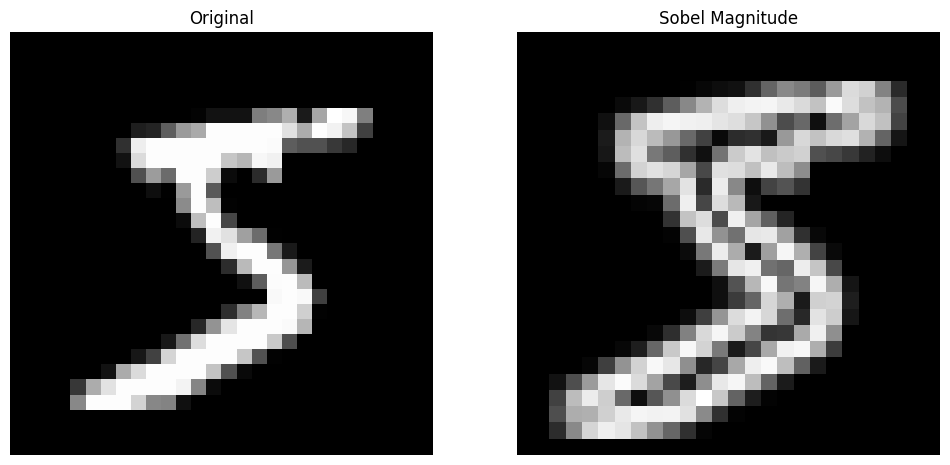

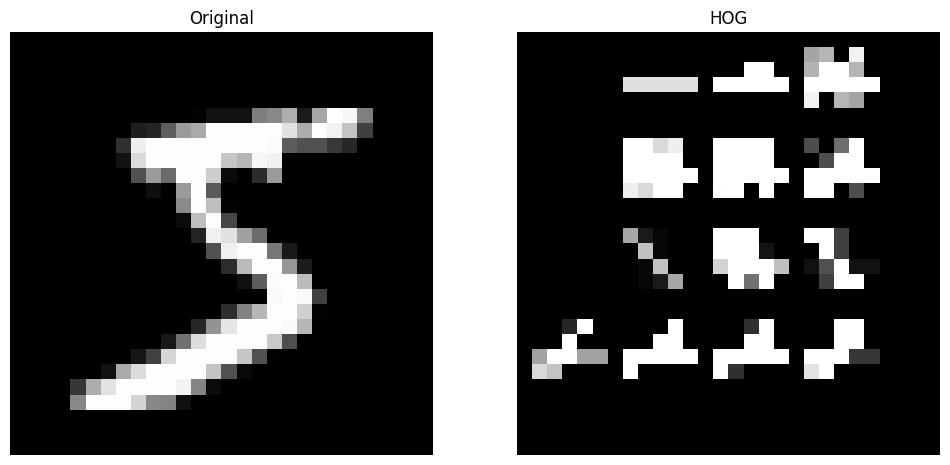

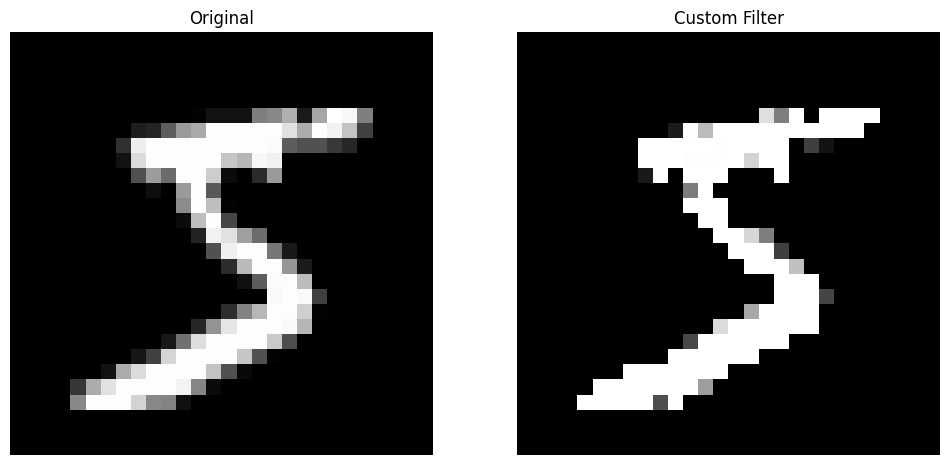

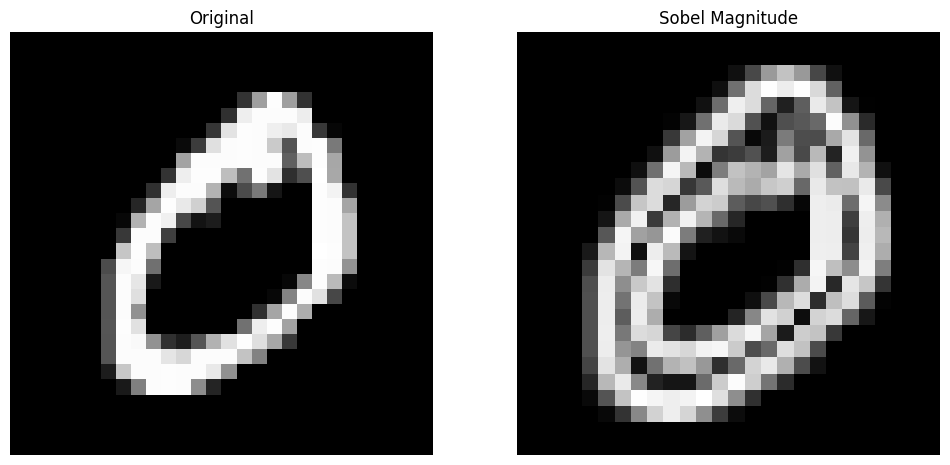

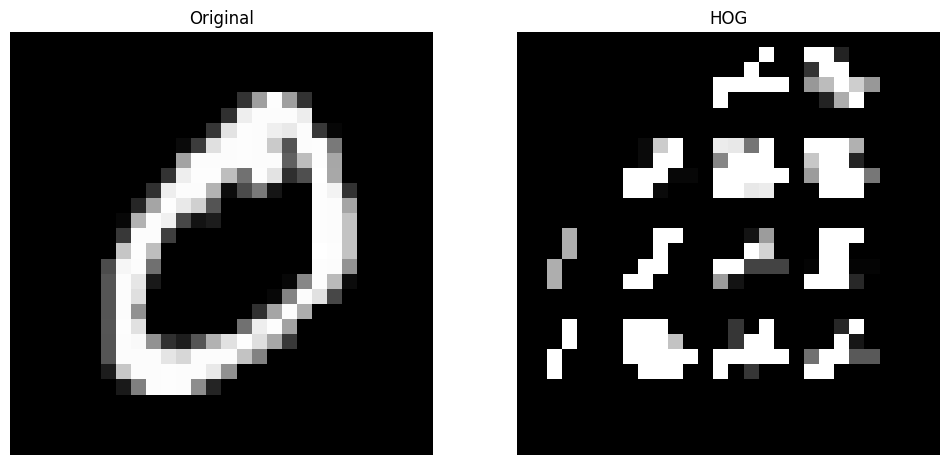

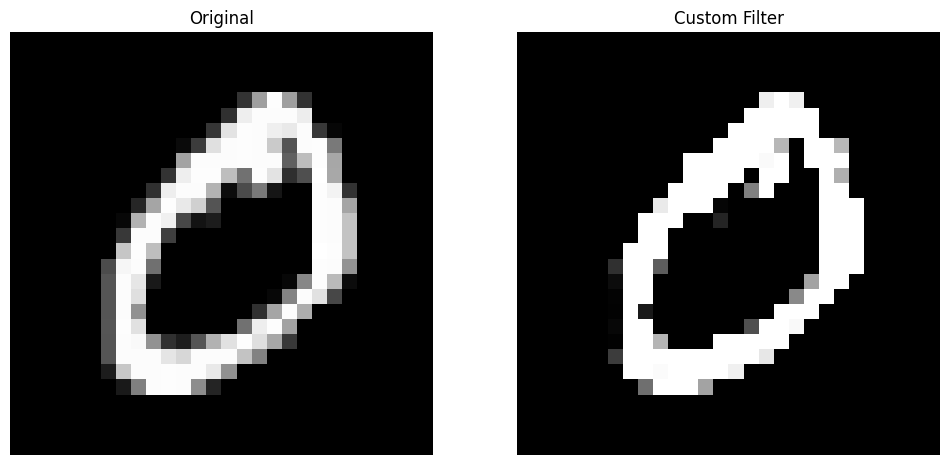

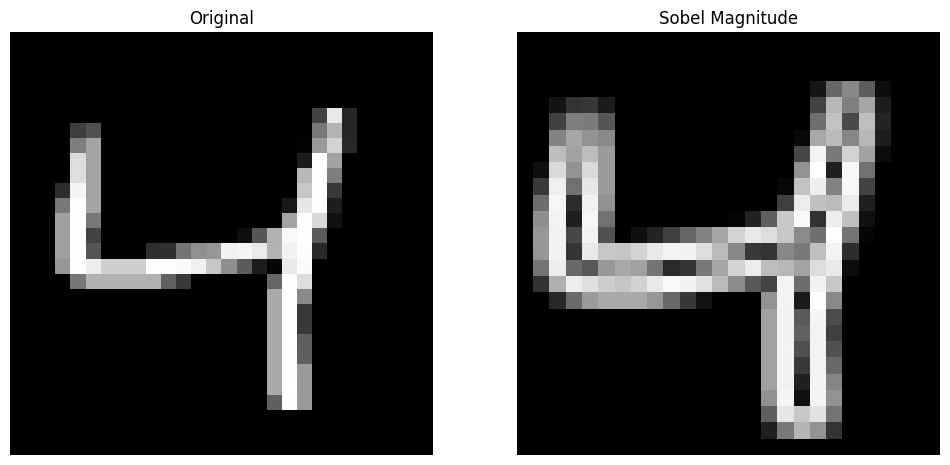

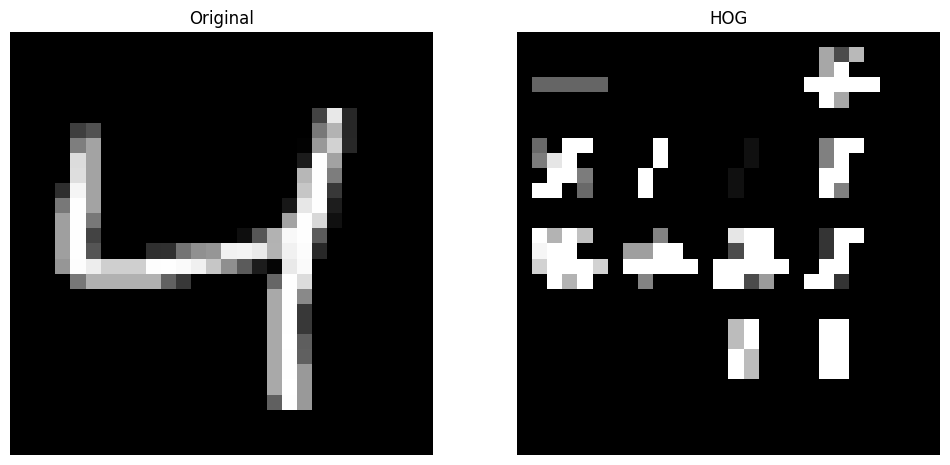

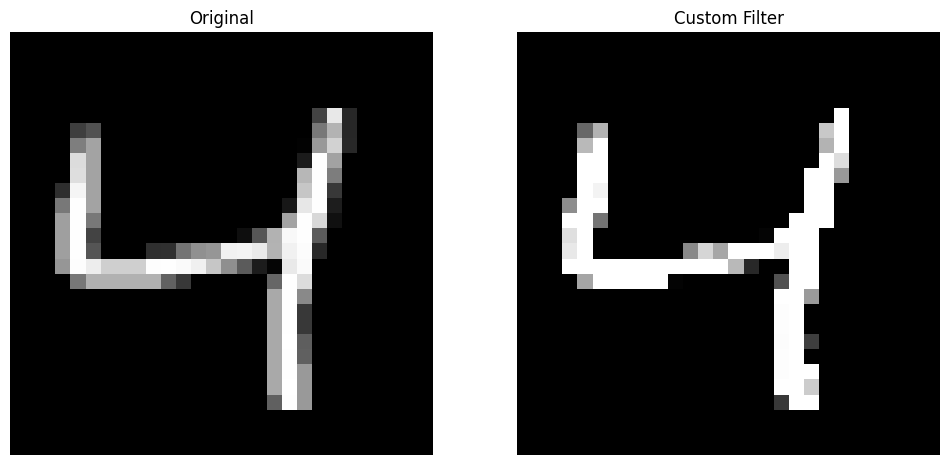

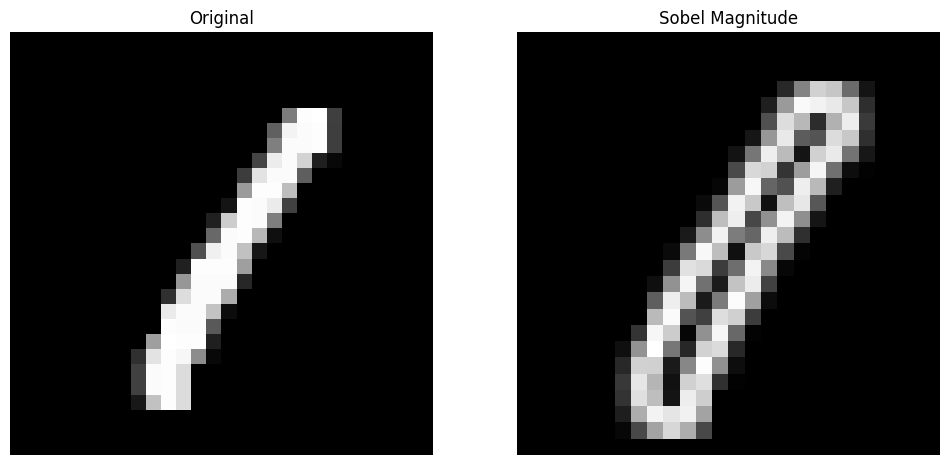

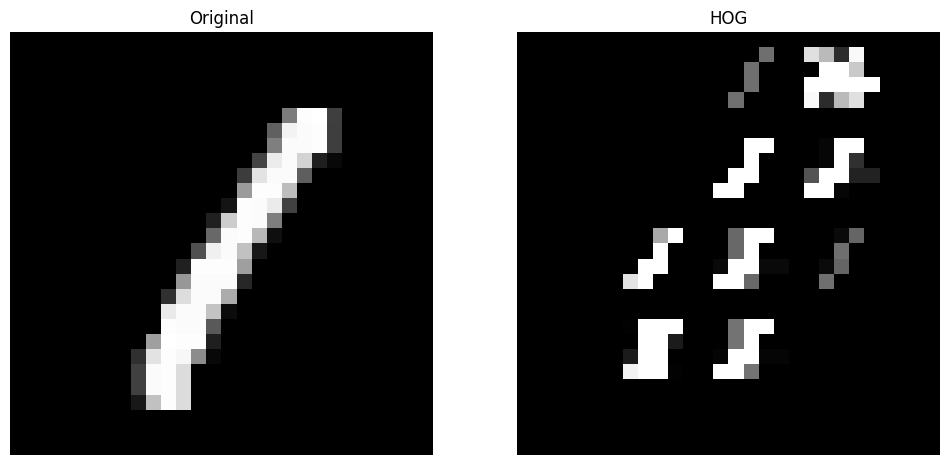

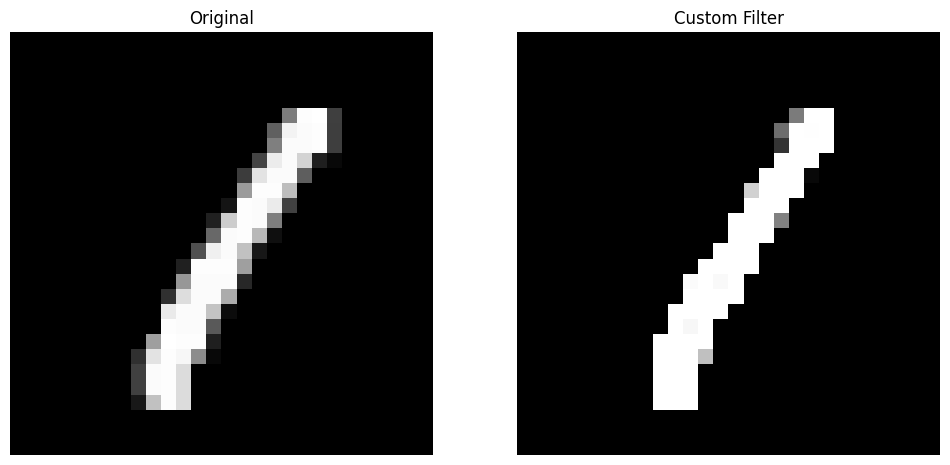

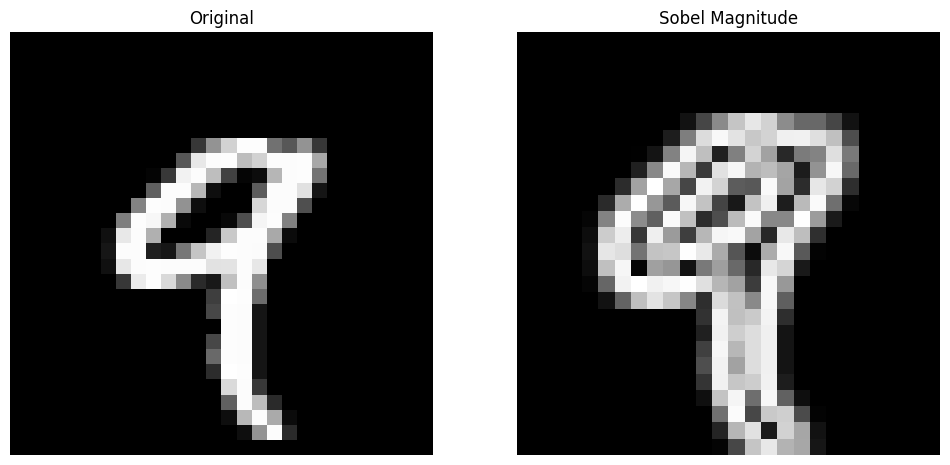

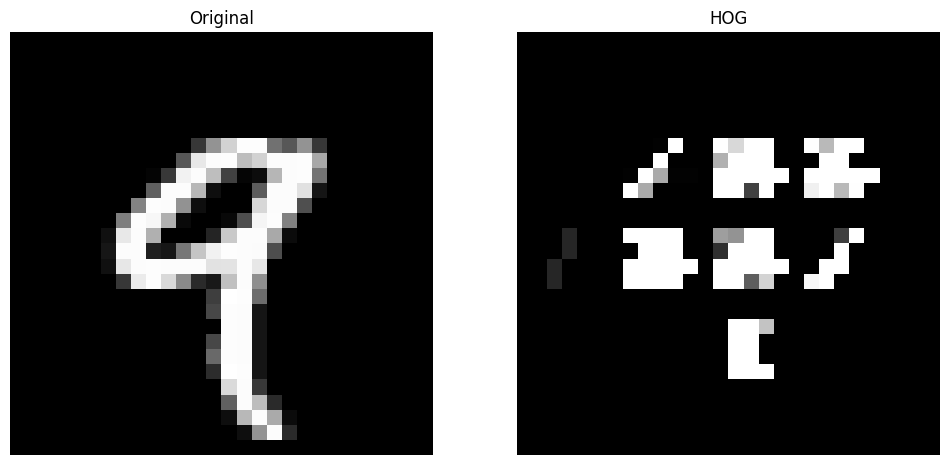

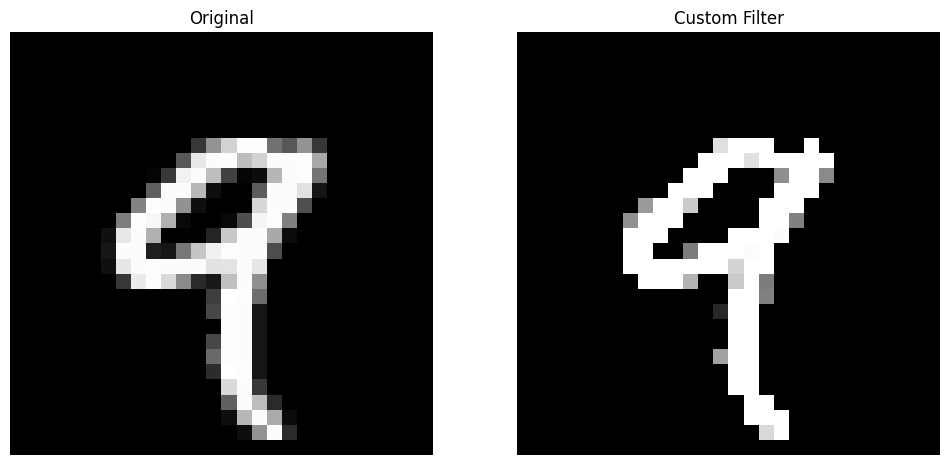

In [7]:
for i in range(5):
    sample_image = images[i]
    edge_image, _ = sobel_filters(sample_image)
    _, hog_image = extract_hog_features(sample_image)
    custom_filtered_img = apply_custom_filter(sample_image, filter_type='sharpen')

    visualize_images(
        [sample_image, edge_image],
        ['Original', 'Sobel Magnitude']
    )
    visualize_images(
        [sample_image, hog_image],
        ['Original', 'HOG']
    )
    visualize_images(
        [sample_image, custom_filtered_img],
        ['Original', 'Custom Filter']
    )

# Phase-2

# Visualize mean of dataset

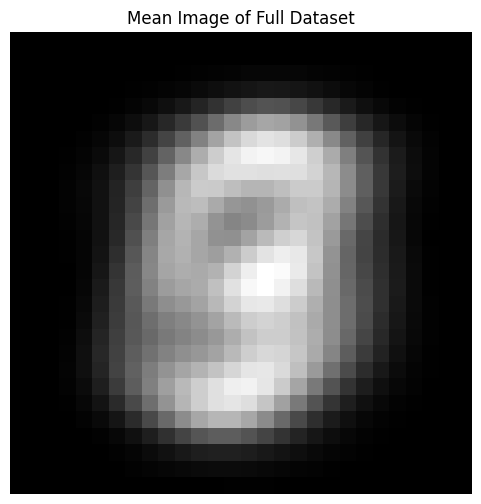

In [8]:
mean_image = calculate_mean_image(images)
visualize_image(mean_image, "Mean Image of Full Dataset")

# Visualize centered images

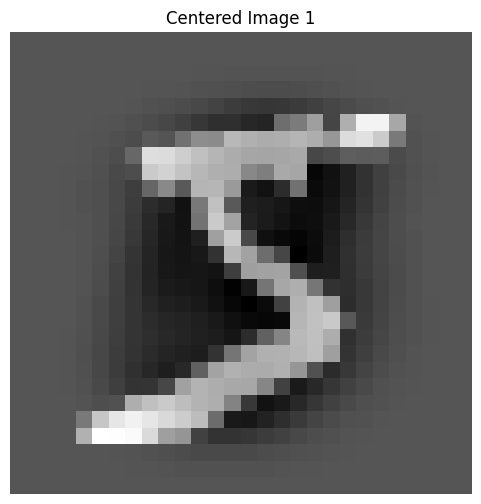

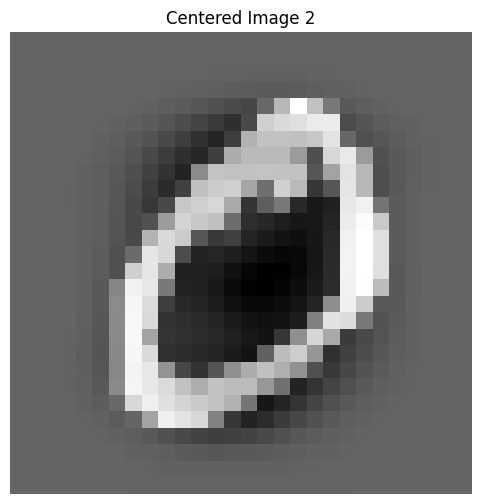

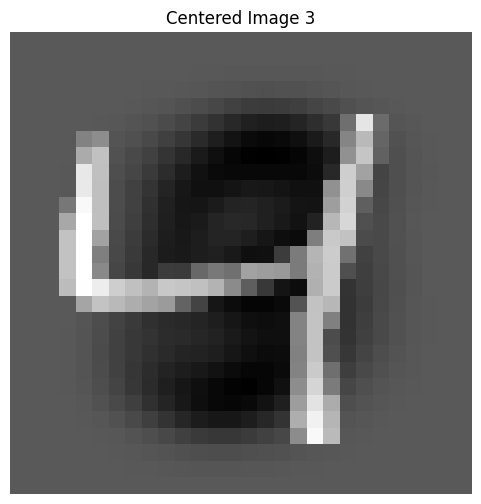

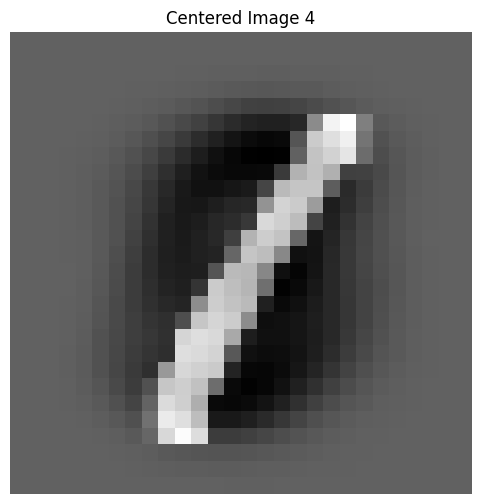

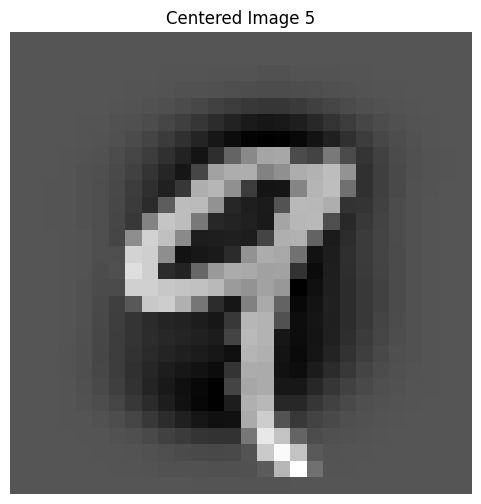

In [9]:
centered_images = center_images(images, mean_image)

for i in range(5):
    visualize_image(centered_images[i], f"Centered Image {i+1}")

# Scree plot for raw data

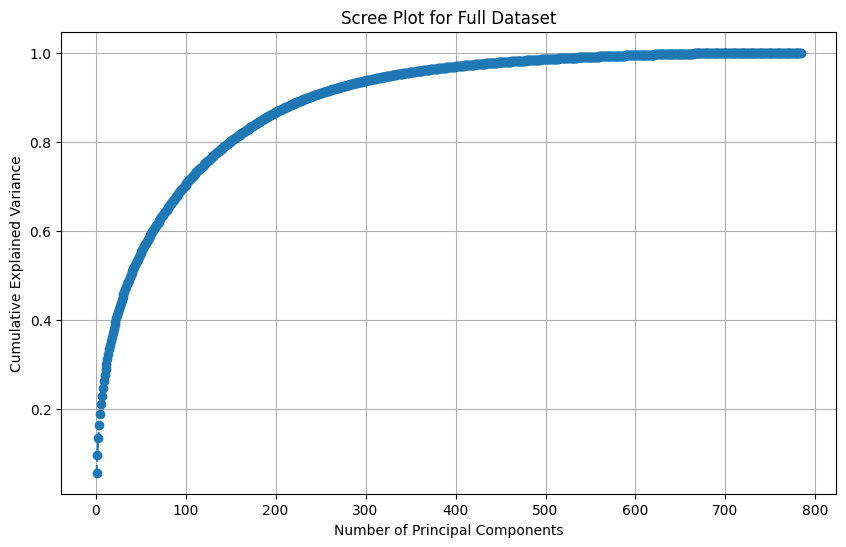

Number of components to retain 80% variance for Full Dataset: 150
PCA Transformed Dataset Shape: (70000, 150)


In [ ]:
if len(images.shape) == 3:
    reshaped_images = images.reshape(images.shape[0], -1)
else:
    reshaped_images = images

pca_transformed_dataset, pca_model = centering_and_pca(reshaped_images, "Full Dataset")

print(f"PCA Transformed Dataset Shape: {pca_transformed_dataset.shape}")

# Scree plot for combined_sobel_hog

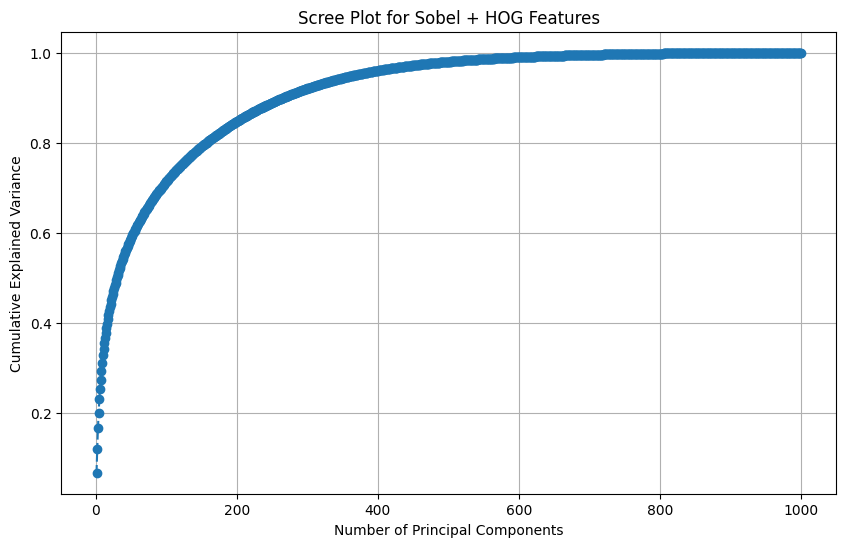

Number of components to retain 80% variance for Sobel + HOG Features: 157
PCA Transformed Sobel + HOG Dataset Shape: (70000, 157)


In [ ]:
sobel_hog_pca, sobel_hog_pca_model = centering_and_pca(combined_sobel_hog, "Sobel + HOG Features")
print(f"PCA Transformed Sobel + HOG Dataset Shape: {sobel_hog_pca.shape}")

# Scree plot for sobel

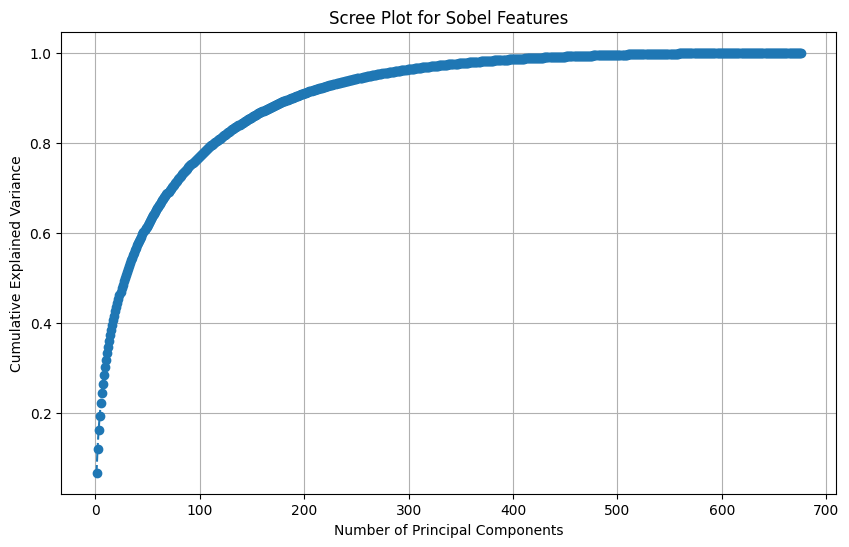

Number of components to retain 80% variance for Sobel Features: 115
PCA Transformed Sobel Features Shape: (70000, 115)


In [ ]:
sobel_pca, sobel_pca_model = centering_and_pca(sobel_features, "Sobel Features")
print(f"PCA Transformed Sobel Features Shape: {sobel_pca.shape}")

# Scree plot for combined_custom_hog

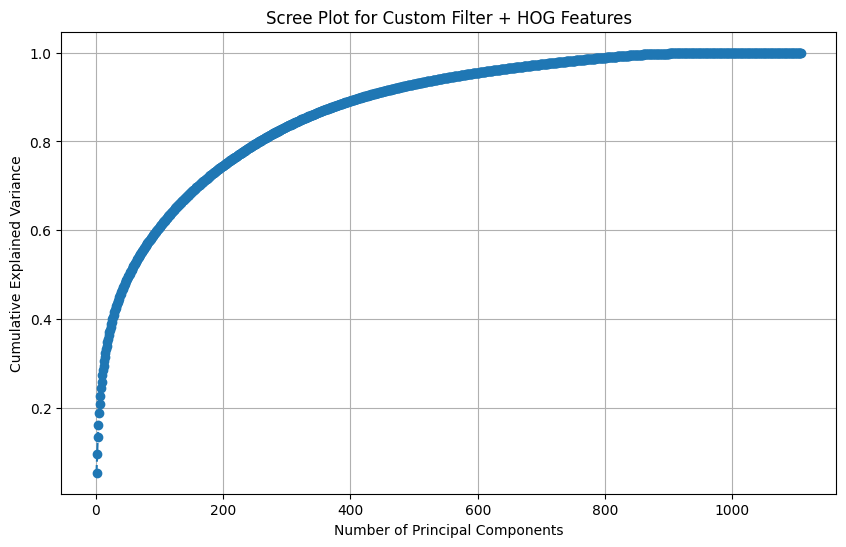

Number of components to retain 80% variance for Custom Filter + HOG Features: 257
PCA Transformed Custom + HOG Features Shape: (70000, 257)


In [ ]:
custom_hog_pca, custom_hog_pca_model = centering_and_pca(combined_custom_hog, "Custom Filter + HOG Features")
print(f"PCA Transformed Custom + HOG Features Shape: {custom_hog_pca.shape}")

# Save and load

In [ ]:
np.save('/content/drive/MyDrive/data/pca_transformed_dataset.npy',pca_transformed_dataset)
np.save('/content/drive/MyDrive/data/sobel_hog_pca.npy',sobel_hog_pca)
np.save('/content/drive/MyDrive/data/sobel_pca.npy',sobel_pca)
np.save('/content/drive/MyDrive/data/custom_hog_pca.npy',custom_hog_pca)

In [10]:
pca_transformed_dataset = np.load('/content/drive/MyDrive/data/pca_transformed_dataset.npy')
sobel_hog_pca = np.load('/content/drive/MyDrive/data/sobel_hog_pca.npy')
sobel_pca = np.load('/content/drive/MyDrive/data/sobel_pca.npy')
custom_hog_pca = np.load('/content/drive/MyDrive/data/custom_hog_pca.npy')

# Phase-3

# Gridsearch

# Split

In [11]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(pca_transformed_dataset, labels, test_size=0.2)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(sobel_hog_pca, labels, test_size=0.2)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(sobel_pca, labels, test_size=0.2)
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(custom_hog_pca, labels, test_size=0.2)

# Raw data

In [ ]:
best_params_1, val_accuracy_1, best_model_1 = perform_grid_search( x_train_1 , x_test_1 , y_train_1 , y_test_1)
print( best_params_1, val_accuracy_1 )

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Validation Accuracy: 0.82
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5} 0.8177857142857143


# Combined_sobel_hog

In [ ]:
best_params_2, val_accuracy_2, best_model_2 = perform_grid_search( x_train_2 , x_test_2 , y_train_2 , y_test_2)
print( best_params_2, val_accuracy_2)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Validation Accuracy: 0.81
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2} 0.8084285714285714


# Sobel

In [ ]:
best_params_3, val_accuracy_3, best_model_3 = perform_grid_search( x_train_3 , x_test_3 , y_train_3 , y_test_3)
print( best_params_3, val_accuracy_3)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Validation Accuracy: 0.80
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5} 0.8023571428571429


# Combined_custom_hog

In [ ]:
best_params_4, val_accuracy_4, best_model_4 = perform_grid_search( x_train_4 , x_test_4 , y_train_4 , y_test_4)
print( best_params_4, val_accuracy_4)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
Validation Accuracy: 0.81
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2} 0.8119285714285714


# Save and Load

In [ ]:
dump(best_model_1, '/content/drive/MyDrive/data/best_model_raw.joblib')
dump(best_model_2, '/content/drive/MyDrive/data/best_model_sobel_hog.joblib')
dump(best_model_3, '/content/drive/MyDrive/data/best_model_sobel.joblib')
dump(best_model_4, '/content/drive/MyDrive/data/best_model_custom_hog.joblib')

['/content/drive/MyDrive/data/best_model_custom_hog.joblib']

In [12]:
best_model_1 = load('/content/drive/MyDrive/data/best_model_raw.joblib')
best_model_2 = load('/content/drive/MyDrive/data/best_model_sobel_hog.joblib')
best_model_3 = load('/content/drive/MyDrive/data/best_model_sobel.joblib')
best_model_4 = load('/content/drive/MyDrive/data/best_model_custom_hog.joblib')

# Decision tree

Raw Data - Feature Names: ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25', 'Feature_26', 'Feature_27', 'Feature_28', 'Feature_29', 'Feature_30', 'Feature_31', 'Feature_32', 'Feature_33', 'Feature_34', 'Feature_35', 'Feature_36', 'Feature_37', 'Feature_38', 'Feature_39', 'Feature_40', 'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45', 'Feature_46', 'Feature_47', 'Feature_48', 'Feature_49', 'Feature_50', 'Feature_51', 'Feature_52', 'Feature_53', 'Feature_54', 'Feature_55', 'Feature_56', 'Feature_57', 'Feature_58', 'Feature_59', 'Feature_60', 'Feature_61', 'Feature_62', 'Feature_63', 'Feature_64', 'Feature_65', 'Feature_66', 'Feature_67', 'Feature_68', 'Feature_69', 'Feature_70', 'F

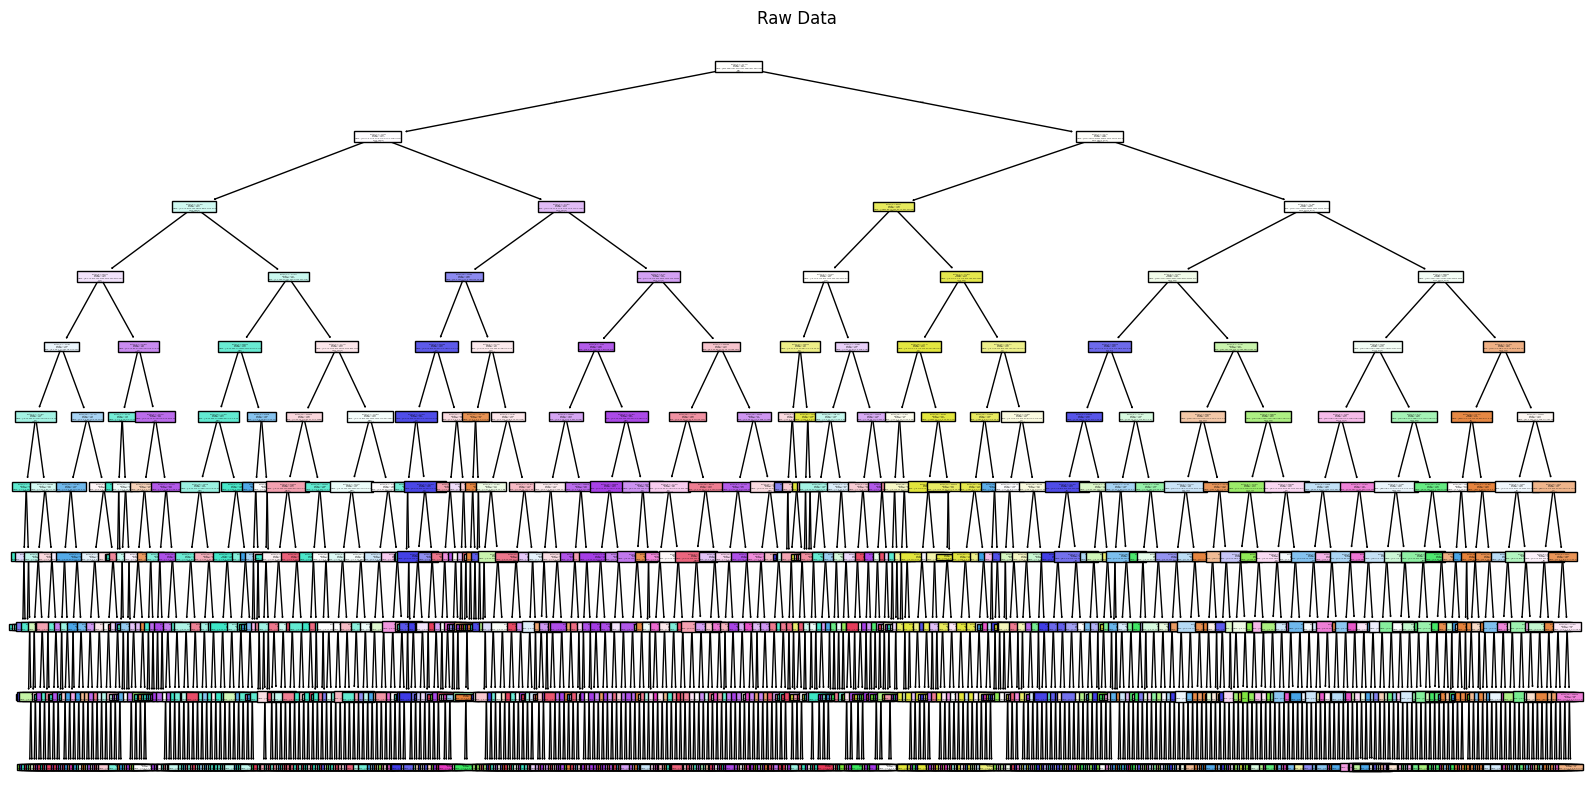

Raw Data - Decision Tree Accuracy: 0.8177857142857143
Combined Sobel HOG - Feature Names: ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25', 'Feature_26', 'Feature_27', 'Feature_28', 'Feature_29', 'Feature_30', 'Feature_31', 'Feature_32', 'Feature_33', 'Feature_34', 'Feature_35', 'Feature_36', 'Feature_37', 'Feature_38', 'Feature_39', 'Feature_40', 'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45', 'Feature_46', 'Feature_47', 'Feature_48', 'Feature_49', 'Feature_50', 'Feature_51', 'Feature_52', 'Feature_53', 'Feature_54', 'Feature_55', 'Feature_56', 'Feature_57', 'Feature_58', 'Feature_59', 'Feature_60', 'Feature_61', 'Feature_62', 'Feature_63', 'Feature_64', 'Feature_65', 'Feature

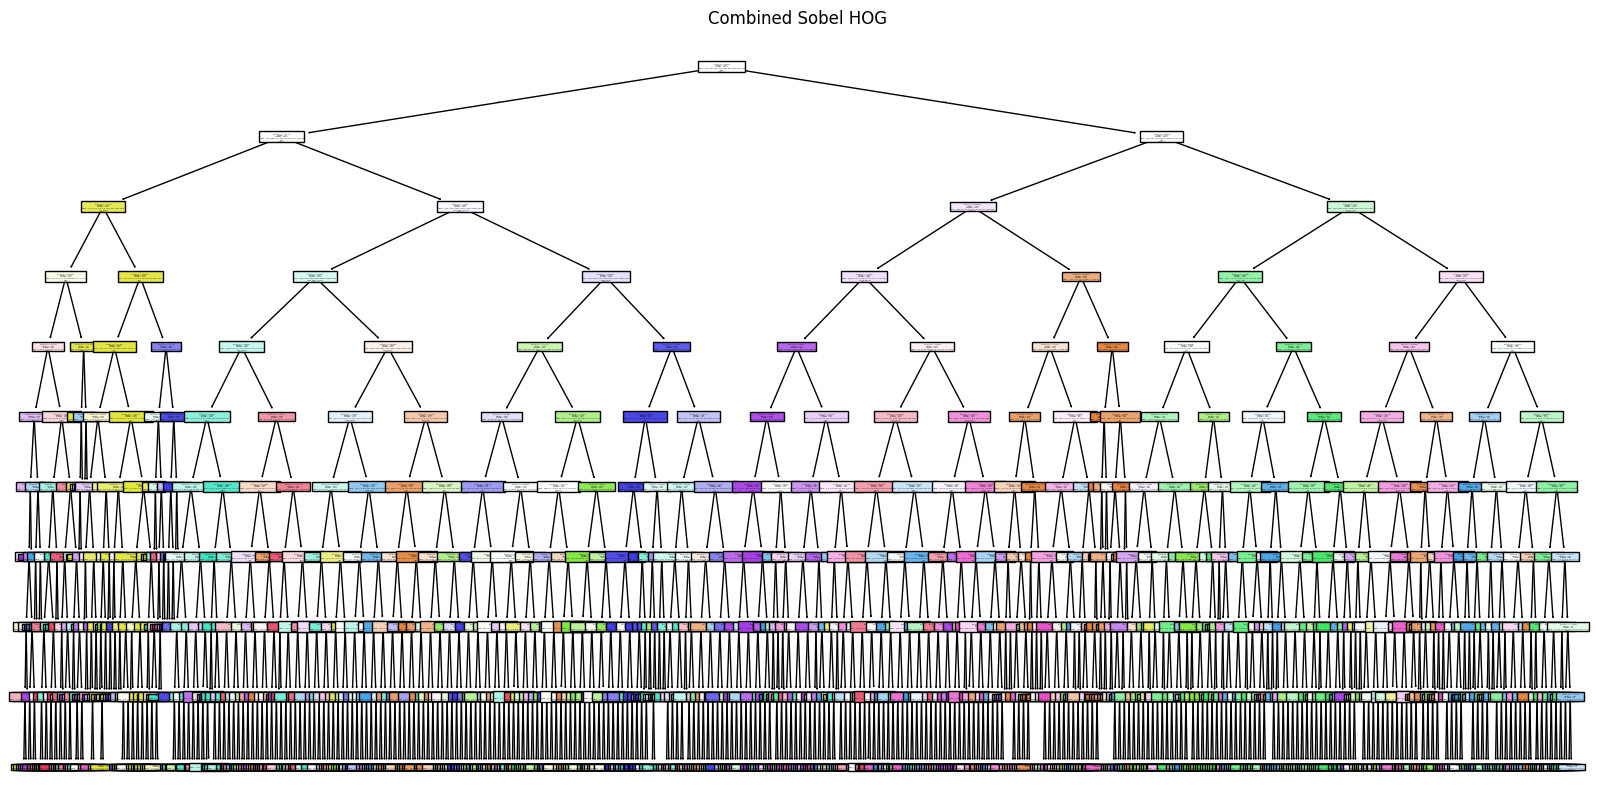

Combined Sobel HOG - Decision Tree Accuracy: 0.8084285714285714
Sobel - Feature Names: ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25', 'Feature_26', 'Feature_27', 'Feature_28', 'Feature_29', 'Feature_30', 'Feature_31', 'Feature_32', 'Feature_33', 'Feature_34', 'Feature_35', 'Feature_36', 'Feature_37', 'Feature_38', 'Feature_39', 'Feature_40', 'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45', 'Feature_46', 'Feature_47', 'Feature_48', 'Feature_49', 'Feature_50', 'Feature_51', 'Feature_52', 'Feature_53', 'Feature_54', 'Feature_55', 'Feature_56', 'Feature_57', 'Feature_58', 'Feature_59', 'Feature_60', 'Feature_61', 'Feature_62', 'Feature_63', 'Feature_64', 'Feature_65', 'Feature_66

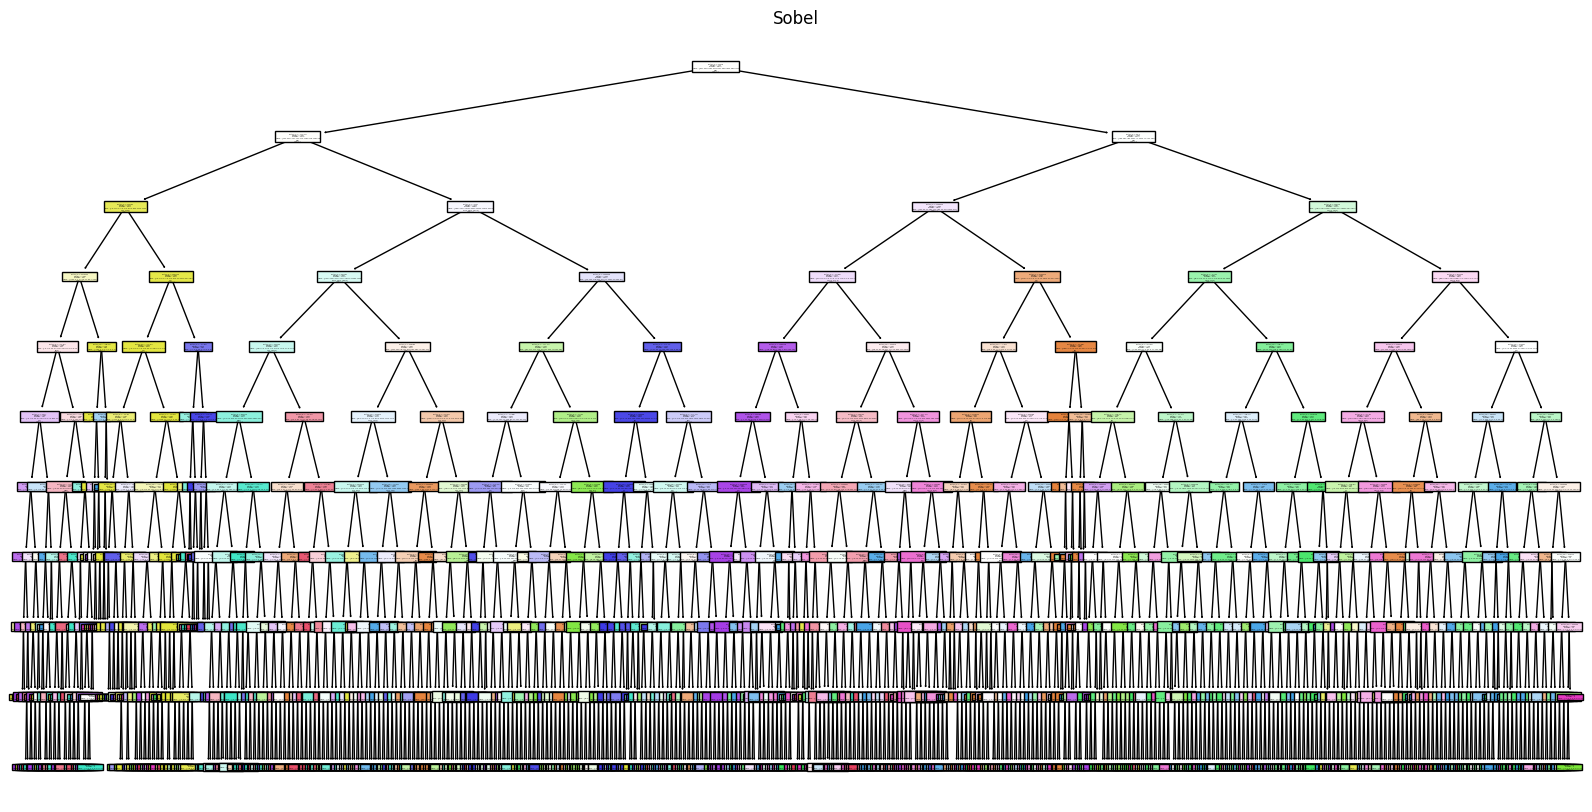

Sobel - Decision Tree Accuracy: 0.8023571428571429
Combined Custom HOG - Feature Names: ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20', 'Feature_21', 'Feature_22', 'Feature_23', 'Feature_24', 'Feature_25', 'Feature_26', 'Feature_27', 'Feature_28', 'Feature_29', 'Feature_30', 'Feature_31', 'Feature_32', 'Feature_33', 'Feature_34', 'Feature_35', 'Feature_36', 'Feature_37', 'Feature_38', 'Feature_39', 'Feature_40', 'Feature_41', 'Feature_42', 'Feature_43', 'Feature_44', 'Feature_45', 'Feature_46', 'Feature_47', 'Feature_48', 'Feature_49', 'Feature_50', 'Feature_51', 'Feature_52', 'Feature_53', 'Feature_54', 'Feature_55', 'Feature_56', 'Feature_57', 'Feature_58', 'Feature_59', 'Feature_60', 'Feature_61', 'Feature_62', 'Feature_63', 'Feature_64', 'Feature_65', 'Feature_6

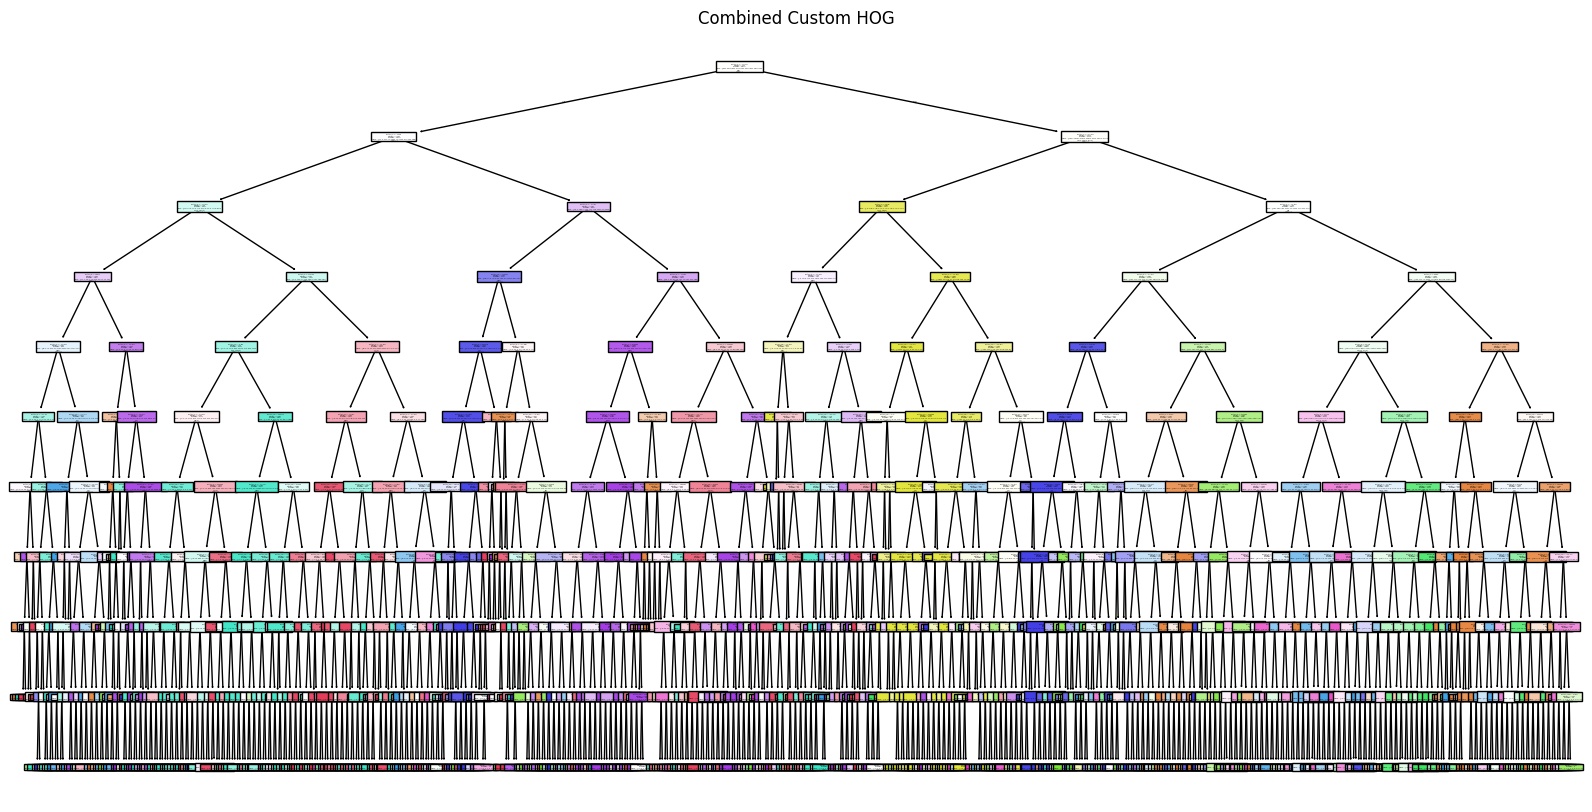

Combined Custom HOG - Decision Tree Accuracy: 0.8119285714285714


In [ ]:
plot_decision_tree(best_model_1, pca_transformed_dataset, labels, x_test_1, y_test_1, "Raw Data")
plot_decision_tree(best_model_2, sobel_hog_pca, labels, x_test_2, y_test_2, "Combined Sobel HOG")
plot_decision_tree(best_model_3, sobel_pca, labels, x_test_3, y_test_3, "Sobel")
plot_decision_tree(best_model_4, custom_hog_pca, labels, x_test_4, y_test_4, "Combined Custom HOG")

# SVM GridSearch

In [ ]:
best_params_1 , best_svm_1 = svm_grid_search(x_train_1,x_test_1, y_train_1 , y_test_1)

In [ ]:
best_params_2 , best_svm_2 = svm_grid_search(x_train_2,x_test_2, y_train_2 , y_test_2)

# SVM-linear (raw data)

In [ ]:
svm_model_raw_data = LinearSVC(random_state=42)
svm_model_raw_data.fit(x_train_1, y_train_1)
accuracy_raw_data = svm_model_raw_data.score(x_test_1, y_test_1)
print("SVM Accuracy on Raw data:", accuracy_raw_data)

# SVM non-linear

In [ ]:
svm_model_raw_data = svm_func(x_train_1,x_test_1, y_train_1 , y_test_1 , 10 , 1)

In [ ]:
svm_model_1, train_acc_1, test_acc_1 = svm_function(x_train_1,x_test_1, y_train_1, y_test_1)

Training Accuracy: 0.9935892857142857
SVM Accuracy: 0.9814285714285714


In [ ]:
svm_model_sobel_hog = svm_func(x_train_2,x_test_2, y_train_2 , y_test_2 , 10 , 1)

In [ ]:
svm_model_2, train_acc_2, test_acc_2 = svm_function(x_train_2,x_test_2, y_train_2 , y_test_2)

Training Accuracy: 0.98925
SVM Accuracy: 0.9712142857142857


# Save and Load (SVM)

In [ ]:
dump(svm_model_1, '/content/drive/MyDrive/data/svm_model_1.joblib')
dump(svm_model_2, '/content/drive/MyDrive/data/svm_model_2.joblib')

['/content/drive/MyDrive/data/svm_model_2.joblib']

In [13]:
svm_model_1 = load('/content/drive/MyDrive/data/svm_model_1.joblib')
svm_model_2 = load('/content/drive/MyDrive/data/svm_model_2.joblib')

# Phase-4

# analysis (DT)

In [ ]:
evaluate_model_performance(best_model_1, x_test_1, y_test_1, labels, "Raw Data")
evaluate_model_performance(best_model_2, x_test_2, y_test_2, labels, "Combined Sobel HOG")
evaluate_model_performance(best_model_3, x_test_3, y_test_3, labels, "Sobel")
evaluate_model_performance(best_model_4, x_test_4, y_test_4, labels, "Combined Custom HOG")

Performance Report for Raw Data:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1314
           1       0.95      0.97      0.96      1584
           2       0.81      0.87      0.84      1392
           3       0.77      0.79      0.78      1450
           4       0.90      0.81      0.85      1374
           5       0.77      0.77      0.77      1266
           6       0.92      0.91      0.91      1386
           7       0.89      0.90      0.89      1484
           8       0.77      0.73      0.75      1333
           9       0.79      0.83      0.81      1417

    accuracy                           0.85     14000
   macro avg       0.85      0.85      0.85     14000
weighted avg       0.85      0.85      0.85     14000

Performance Report for Combined Sobel HOG:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1406
           1       0.97      0.97      0.97      1611
  

# analysis (SVM)

In [ ]:
evaluate_model_performance(svm_model_1, x_test_1, y_test_1, labels, "Raw Data")
evaluate_model_performance(svm_model_2, x_test_2, y_test_2, labels, "Combined Sobel HOG")

Performance Report for Raw Data:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1314
           1       0.99      0.99      0.99      1584
           2       0.99      0.99      0.99      1392
           3       0.99      0.99      0.99      1450
           4       0.99      0.99      0.99      1374
           5       1.00      0.99      0.99      1266
           6       0.99      1.00      1.00      1386
           7       0.99      0.99      0.99      1484
           8       0.99      0.99      0.99      1333
           9       0.98      0.98      0.98      1417

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000

Performance Report for Combined Sobel HOG:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1406
           1       0.99      1.00      1.00      1611
  

# Confusion_matrix

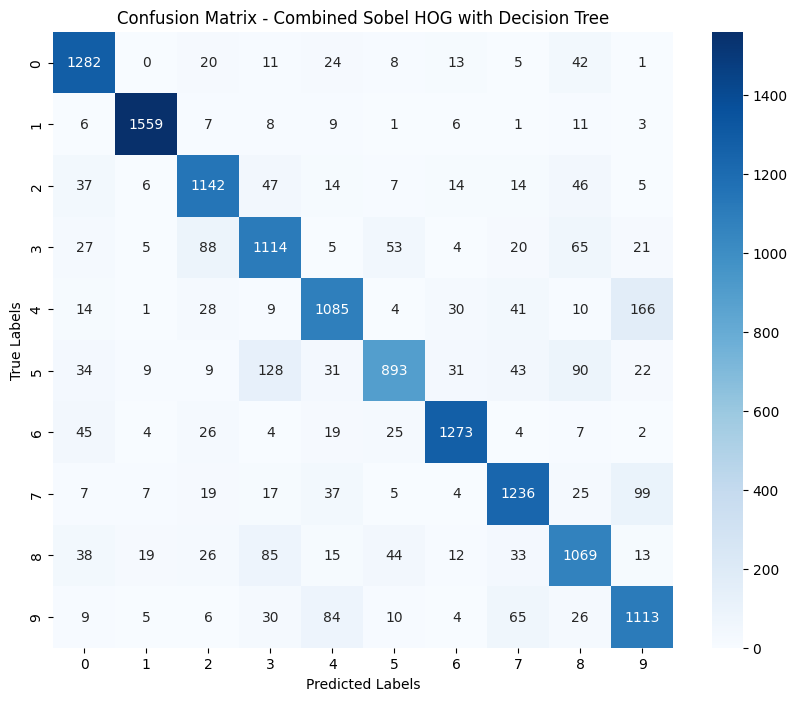

In [ ]:
class_names = np.unique(labels).astype(str)
plot_confusion_matrix(best_model_2, x_test_2, y_test_2, class_names, title="Confusion Matrix - Combined Sobel HOG with Decision Tree")

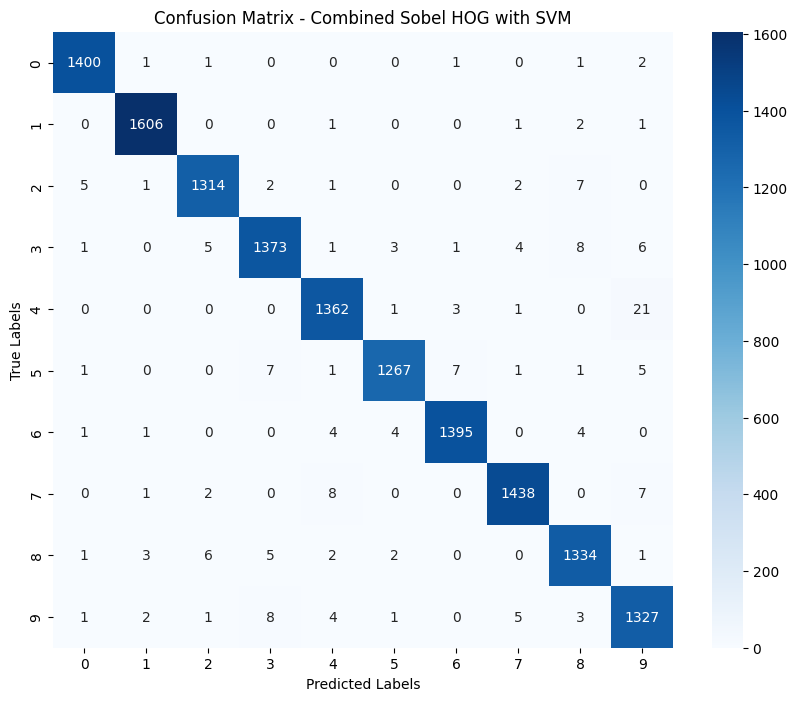

In [ ]:
class_names = np.unique(labels).astype(str)
plot_confusion_matrix(svm_model_2, x_test_2, y_test_2, class_names, title="Confusion Matrix - Combined Sobel HOG with SVM")

# Phase-5

# Overfitting

In [19]:
train_acc_overfit, test_acc_overfit, overfit_model = train_and_evaluate_decision_tree(
    x_train_2, y_train_2, x_test_2, y_test_2,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    criterion='gini',
    title="Overfit Model"
)

Overfit Model - Train Accuracy: 1.00
Overfit Model - Test Accuracy: 0.81


# overfit heatmap

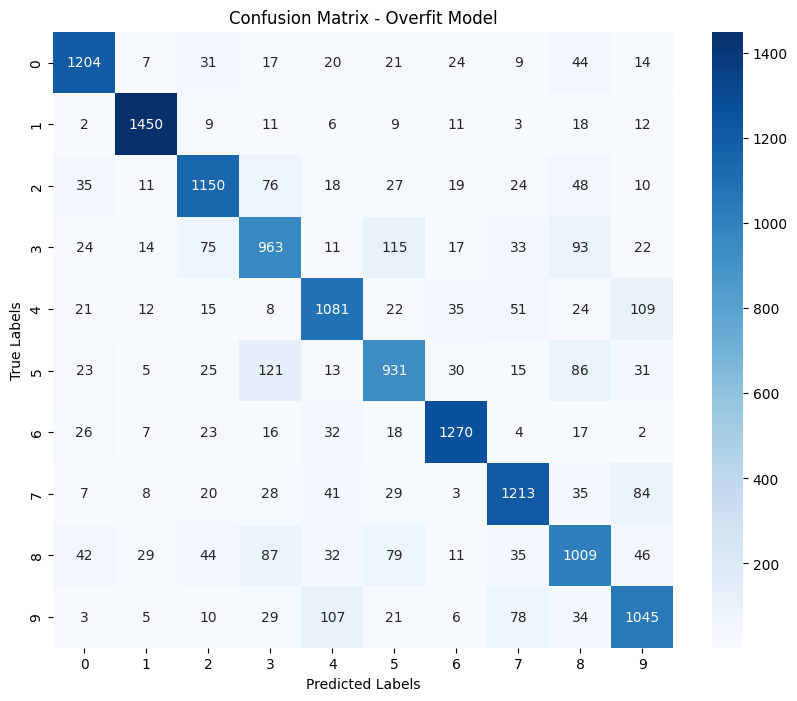

In [22]:
class_names = np.unique(labels).astype(str)
plot_confusion_matrix(overfit_model, x_test_2, y_test_2, labels=class_names, title="Confusion Matrix - Overfit Model")

# Pre-Pruned

In [23]:
train_acc_pruned, test_acc_pruned, pruned_model = train_and_evaluate_decision_tree(
    x_train_2, y_train_2, x_test_2, y_test_2,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    criterion='gini'
)

Model - Train Accuracy: 0.81
Model - Test Accuracy: 0.78


# Pre-Pruned heatmap

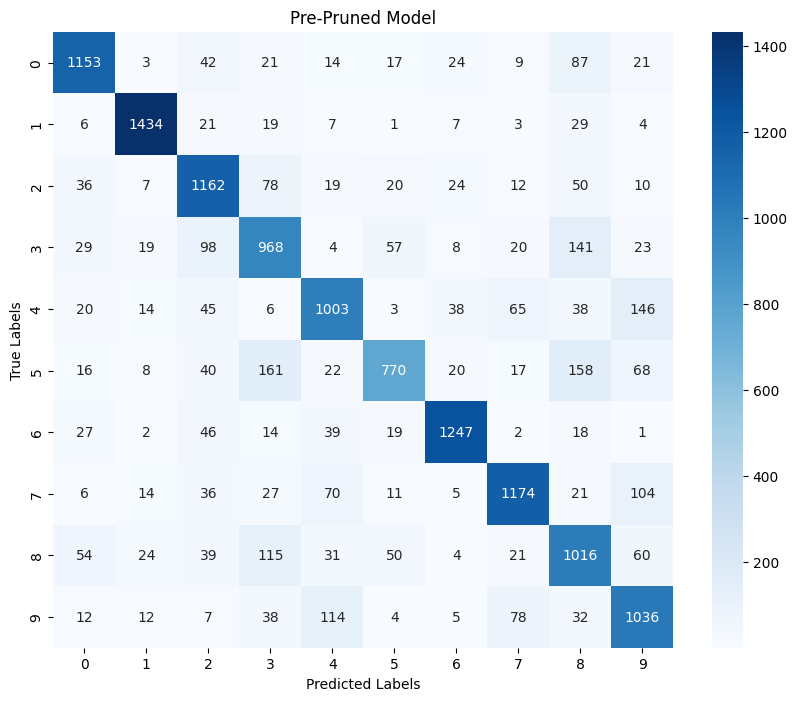

In [24]:
class_names = np.unique(labels).astype(str)
plot_confusion_matrix(pruned_model, x_test_2, y_test_2, labels=class_names, title="Pre-Pruned Model")